# LSTM Text Classification

DataSet: https://www.kaggle.com/datasets/kazanova/sentiment140

## Import Dependencies

In [20]:
import random
import pandas as pd
import matplotlib.pyplot as plt

from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import SpatialDropout1D
from keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter("ignore")

## Dataset Preprocessing

In [ ]:
import csv

# Specify the input and output file paths
input_file = 'dataset.csv'
output_file = 'Text_Classification.csv'

# Specify the row numbers to extract
rows_to_extract = set(range(1, 100_001)) | set(range(800_001, 900_001))

with open(input_file, 'r', newline='') as csvfile, open(output_file, 'w', newline='') as outfile:
    reader = csv.reader(csvfile)
    writer = csv.writer(outfile)
    row_count = 0

    for row in reader:
        row_count += 1

        if row_count in rows_to_extract:
            writer.writerow(row)

        if row_count >= 900001:
            break

In [3]:
df = pd.read_csv('Text_Classification.csv', encoding='latin', header=None)
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
df.columns = ['class', 'id', 'date', 'query', 'user_id', 'message']
df.drop(['id', 'date', 'query', 'user_id'], axis=1, inplace=True)

# save new dataframe to csv
df.to_csv("Text_Classification_Update.csv")
df.head()

,class,message
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [5]:
label_to_sentiment = {0:'Negative', 4:'Positive'}
df['class'] = df['class'].apply(lambda x: label_to_sentiment[x])
df.head()

,class,message
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."


In [8]:
random_idx_list = [random.randint(1, len(df['message'])) for i in range(10)]
df.loc[random_idx_list,:].head(10)

,class,message
99267,Negative,Sad news: my gran died last night. Not unexpec...
88884,Negative,"off people, wish me luck for tmrrw! todays kin..."
134988,Positive,@angelinexo I can't wait for you to hear it!...
141204,Positive,@jasonmoffatt's birthday today. A spank from t...
22771,Negative,@kath_o_the_leen - would be good but their lea...
385,Negative,"@soillodge yes, it will be. it's only Monday"
79537,Negative,@theberaca yes you would you psycho woman! Ahh...
18751,Negative,@MiseryXchord I like some of The Killers' mus...
75214,Negative,@chelsea_playboy WHAT HAPPENED TO THEM? i miss...
73726,Negative,@tomfelton http://twitpic.com/4jam0 - Looks Lo...


## Data Visualization

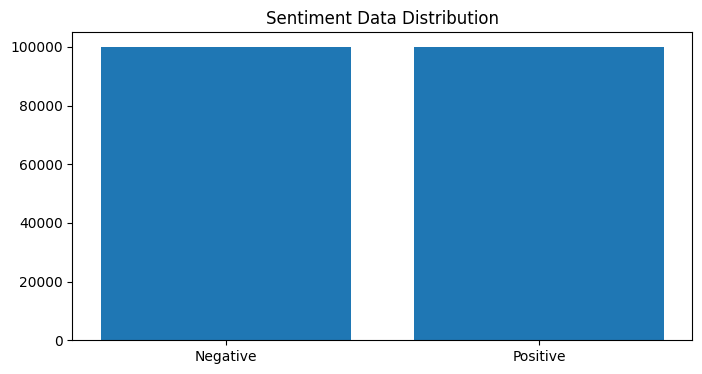

In [37]:
val_count = df['class'].value_counts()

plt.figure(figsize=(8, 4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")
plt.show()

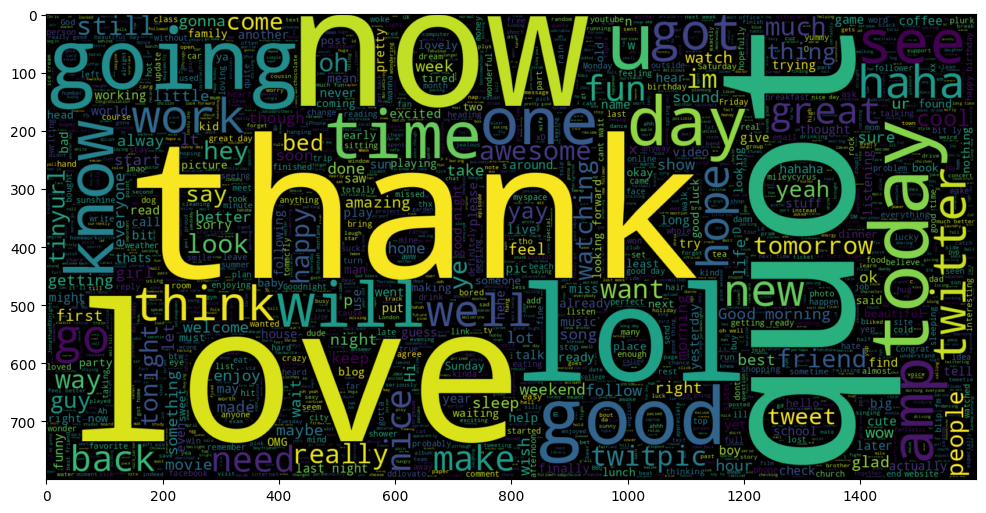

In [40]:
from wordcloud import WordCloud

plt.figure(figsize = (12, 12)) 
wc = WordCloud(
    max_words = 2000 , width = 1600 , height = 800
).generate(" ".join(df[df['class'] == 'Positive'].message))
plt.imshow(wc , interpolation = 'bilinear')
plt.show()

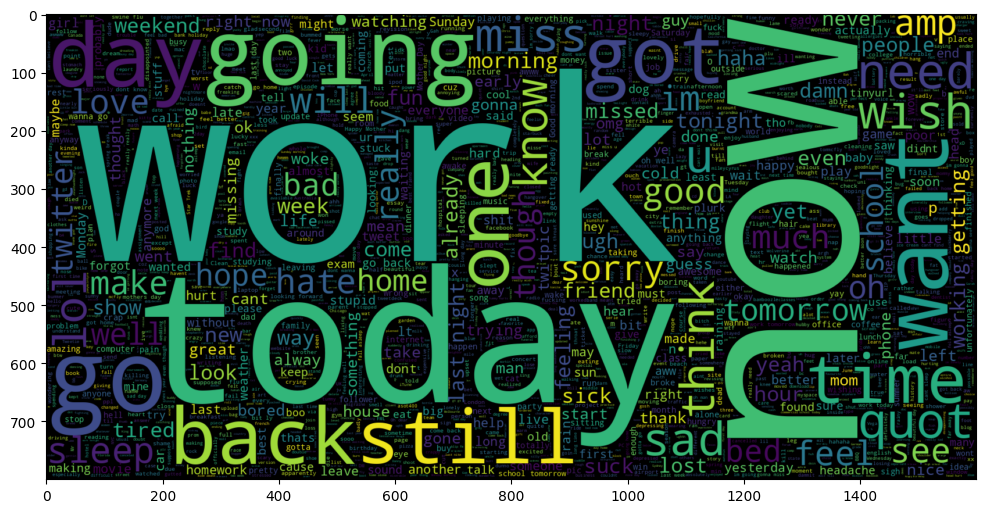

In [41]:
plt.figure(figsize = (12, 12)) 
wc = WordCloud(
    max_words = 2000 , width = 1600 , height = 800
).generate(" ".join(df[df['class'] == 'Negative'].message))
plt.imshow(wc , interpolation = 'bilinear')
plt.show()

## Text Preprocessing

In [9]:
df['word_length'] = df['message'].str.split()
df['word_length'] = df['word_length'].str.len()
df.dropna(inplace=True)

In [10]:
df['word_length'].sort_values(ascending=False)

170822    38
152964    36
130716    35
40870     35
82714     35
          ..
70451      1
70431      1
147832     1
196756     1
110255     1
Name: word_length, Length: 200000, dtype: int64

In [11]:
MAX_WORDS = 3000
MAX_SEQUENCE_LENGTH = 64
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~')
tokenizer.fit_on_texts(df.message.values)
word_index = tokenizer.word_index
X = tokenizer.texts_to_sequences(df.message.values)

In [12]:
df.message.values[0]

"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

In [13]:
X[0]

[42, 147, 51, 539, 142, 4, 1312, 7, 50, 734, 12, 2083, 30, 2, 40, 9, 406]

## Train and Test Split

In [15]:
train_size = 0.8

X = pad_sequences(X, maxlen = MAX_SEQUENCE_LENGTH)
Y = df['class']
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size = 1 - train_size, random_state = 1234
)

print(f"Train Data size: {len(X_train):,}")
print(f"Test  Data size: {len(X_test):,}")

Train Data size: 160,000
Test  Data size: 40,000


In [16]:
labels = Y_train.unique().tolist()

encoder = LabelEncoder()
encoder.fit(Y_train.to_list())

Y_train = encoder.transform(Y_train.to_list())
Y_test = encoder.transform(Y_test.to_list())

Y_train = Y_train.reshape(-1, 1)
Y_test = Y_test.reshape(-1, 1)

print("y_train shape:", Y_train.shape)
print("y_test shape:", Y_test.shape)

y_train shape: (160000, 1)
y_test shape: (40000, 1)


In [17]:
X_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    1,  938,    3,  928,   10,    3,  353,  129,  128,   73,
          7,   50,    1,  514,  546,    2,   46, 1717, 2446], dtype=int32)

In [18]:
Y_train[0:10]

array([[0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0]])

## Model Training

In [21]:
epochs = 5
batch_size = 64
learning_rate = 1e-3

model = Sequential()
model.add(Embedding(MAX_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1)

Epoch 1/5
2250/2250 [==============================] - 262s 116ms/step - loss: 0.4804 - accuracy: 0.7685 - val_loss: 0.4437 - val_accuracy: 0.7912
Epoch 2/5
2250/2250 [==============================] - 265s 118ms/step - loss: 0.4348 - accuracy: 0.7960 - val_loss: 0.4382 - val_accuracy: 0.7984
Epoch 3/5
2250/2250 [==============================] - 268s 119ms/step - loss: 0.4169 - accuracy: 0.8064 - val_loss: 0.4289 - val_accuracy: 0.8046
Epoch 4/5
2250/2250 [==============================] - 267s 119ms/step - loss: 0.4035 - accuracy: 0.8140 - val_loss: 0.4265 - val_accuracy: 0.8031
Epoch 5/5
2250/2250 [==============================] - 266s 118ms/step - loss: 0.3922 - accuracy: 0.8198 - val_loss: 0.4305 - val_accuracy: 0.8026


## Model Evaluation

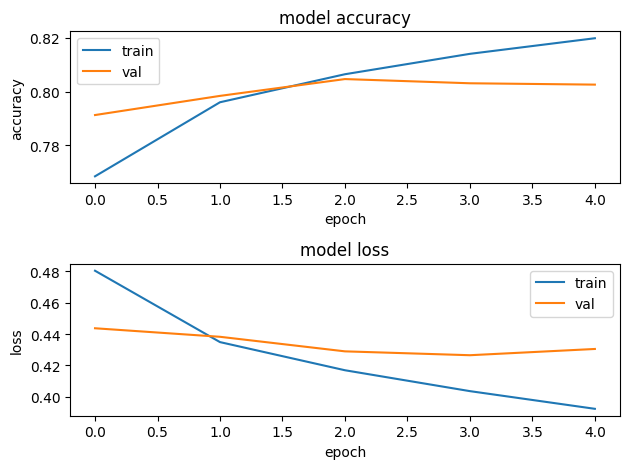

In [23]:
fig, (at, al) = plt.subplots(2, 1)

at.plot(history.history['accuracy'])
at.plot(history.history['val_accuracy'])
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['train', 'val'])

al.plot(history.history['loss'])
al.plot(history.history['val_loss'])
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'])

fig.tight_layout()
plt.show()

In [24]:
accuracy = model.evaluate(X_test, Y_test, verbose=0)
print(f'Test set\nLoss: {accuracy[0]:.3f}\nAccuracy: {accuracy[1]:.3f}')

Test set
Loss: 0.437
Accuracy: 0.798


In [25]:
def decode(score):
    return "Positive" if score > 0.5 else "Negative"

def test(posts):
    X = tokenizer.texts_to_sequences(posts)
    X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
    scores = model.predict(X, verbose=0)
    return [decode(score) for score in scores]

In [26]:
posts = [
    "Absolutely loved the new movie! The acting was superb, and the plot kept me engaged throughout. Highly recommend it to everyone! #MovieMagic",
    "Extremely disappointed with the customer service. They were unresponsive and unhelpful throughout the entire process. Will not be recommending this company to anyone. #PoorService"
]
test(posts)

['Positive', 'Negative']

In [27]:
scores = model.predict(X_test, verbose=0, batch_size=10_000)
Y_predict = [decode(score) for score in scores]
Y_test = [decode(y) for y in Y_test]

              precision    recall  f1-score   support

    Negative       0.79      0.81      0.80     19991
    Positive       0.81      0.78      0.79     20009

    accuracy                           0.80     40000
   macro avg       0.80      0.80      0.80     40000
weighted avg       0.80      0.80      0.80     40000




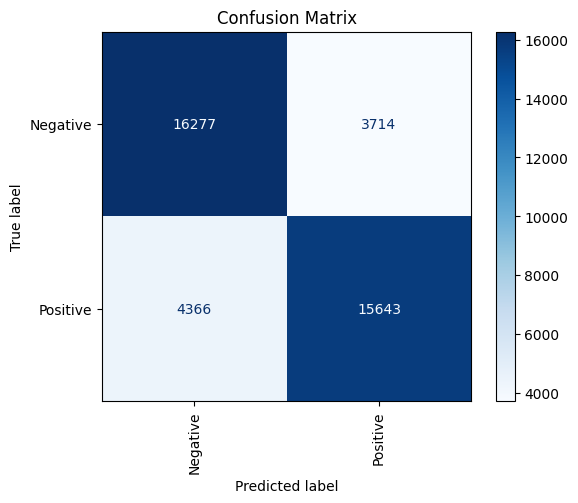

In [29]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay

report = classification_report(Y_test, Y_predict)
matrix = confusion_matrix(Y_test, Y_predict)
display = ConfusionMatrixDisplay(
    confusion_matrix=matrix, display_labels=['Negative', "Positive"]
)

# display cconfusion matrix
print(f"{report}\n")
display.plot(cmap=plt.cm.Blues, values_format='g')
plt.xticks(rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

## Fine Tuning model


In [30]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

batch_size = 64

# Increase the number of epochs
epochs = 10

# Decrease the learning rate
learning_rate = 1e-4

model = Sequential()
model.add(Embedding(MAX_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])

# Automatically reduces the learning rate (LR) during training based on a specified condition
reduce_lr = ReduceLROnPlateau(
    factor=0.1, min_lr=0.01, monitor='val_loss', verbose=1
)

history = model.fit(
    X_train, Y_train, epochs=epochs, batch_size=batch_size, 
    validation_split=0.1, callbacks=[reduce_lr]
)

Epoch 1/10
2250/2250 [==============================] - 263s 116ms/step - loss: 0.5468 - accuracy: 0.7250 - val_loss: 0.4661 - val_accuracy: 0.7844
Epoch 2/10
2250/2250 [==============================] - 261s 116ms/step - loss: 0.4645 - accuracy: 0.7834 - val_loss: 0.4507 - val_accuracy: 0.7923
Epoch 3/10
2250/2250 [==============================] - 265s 118ms/step - loss: 0.4528 - accuracy: 0.7893 - val_loss: 0.4475 - val_accuracy: 0.7916
Epoch 4/10
2250/2250 [==============================] - 269s 119ms/step - loss: 0.4473 - accuracy: 0.7919 - val_loss: 0.4460 - val_accuracy: 0.7928
Epoch 5/10
2250/2250 [==============================] - 269s 119ms/step - loss: 0.4433 - accuracy: 0.7942 - val_loss: 0.4446 - val_accuracy: 0.7925
Epoch 6/10
2250/2250 [==============================] - 268s 119ms/step - loss: 0.4396 - accuracy: 0.7958 - val_loss: 0.4450 - val_accuracy: 0.7921
Epoch 7/10
2250/2250 [==============================] - 268s 119ms/step - loss: 0.4361 - accuracy: 0.7974 - val_

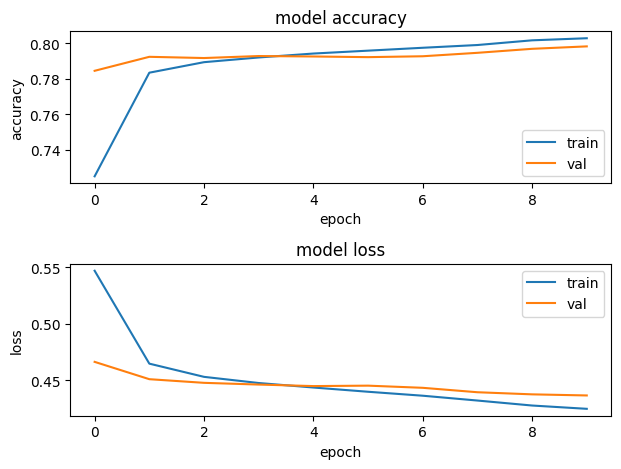

In [31]:
fig, (at, al) = plt.subplots(2, 1)

at.plot(history.history['accuracy'])
at.plot(history.history['val_accuracy'])
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['train', 'val'])

al.plot(history.history['loss'])
al.plot(history.history['val_loss'])
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'])

fig.tight_layout()
plt.show()

In [35]:
scores = model.predict(X_test, verbose=0, batch_size=10_000)
Y_predict = [decode(score) for score in scores]

              precision    recall  f1-score   support

    Negative       0.79      0.80      0.79     19991
    Positive       0.80      0.79      0.79     20009

    accuracy                           0.79     40000
   macro avg       0.79      0.79      0.79     40000
weighted avg       0.79      0.79      0.79     40000




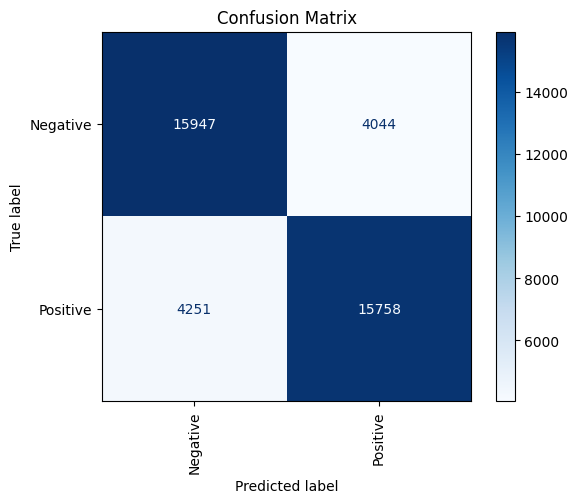

In [36]:
report = classification_report(Y_test, Y_predict)
matrix = confusion_matrix(Y_test, Y_predict)
display = ConfusionMatrixDisplay(
    confusion_matrix=matrix, display_labels=['Negative', "Positive"]
)

# display cconfusion matrix
print(f"{report}\n")
display.plot(cmap=plt.cm.Blues, values_format='g')
plt.xticks(rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

## Saving and Reloading

In [34]:
from tensorflow.keras.models import load_model

# save model
model.save('classify_model.h5')

In [ ]:
# load model
model = load_model('classify_model.h5')